# [TI] 01 - Méthode de seuillage d'Otsu

Les cellules de code en Python permettent de charger une image à partir du Drive Google, puis d'afficher le résultat du seuillage.

In [7]:
%%writefile image.h

#ifndef __Image_h
#define __Image_h

#include <cmath>
#include <iostream>
#include <vector>
#include <limits>
#include <fstream>
#include <string>
#include <sstream>
#include <functional>
#include <algorithm>

namespace v2_0
{
    const double pi{ std::acos(-1.0) };

    template <typename T>
    class Image
    {
        using image_type = std::vector< std::vector< T > >;

    protected:
        image_type m_pixels;
        std::size_t m_width, m_height;

    public:
        Image(std::size_t width = 0, std::size_t height = 0);

        T& operator()(int i, int j) { return m_pixels[i][j]; }
        const T& operator()(int i, int j) const { return m_pixels[i][j]; }

        int getWidth() { return m_width; }
        int getWidth() const { return m_width; }
        int getHeight() { return m_height; }
        int getHeight() const { return m_height; }

        void white();
        void sinus(int n = 1);
        void checkerboard(int nx, int ny);
        void fill(const std::function<double(int,int)>& f);

        template<typename U>
        Image<U> convert(bool rescale = false);

        bool read(const std::string& fileName, bool littleEndian = true);
        void write(const std::string& fileName);
    };

    template<typename T>
    Image<T>::Image(std::size_t width, std::size_t height)
        : m_width(width), m_height(height)
    {
        m_pixels = image_type(width);
        for (std::size_t i{ 0 }; i < width; ++i)
            m_pixels[i] = std::vector<T>(height);
    }

    template<typename T>
    void Image<T>::white()
    {
        for (std::size_t i{ 0 }; i < m_width; ++i)
            for (std::size_t j{ 0 }; j < m_height; ++j)
                m_pixels[i][j] = std::numeric_limits<T>::max();
    }

    template<typename T>
    void Image<T>::sinus(int n)
    {
        for (std::size_t i{ 0 }; i < m_width; ++i)
        {
            T value{ static_cast<T>(std::sin(2 * pi * n * i / (m_width - 1))) };
            for (std::size_t j{ 0 }; j < m_height; ++j)
                m_pixels[i][j] = value;
        }
    }

    template<typename T>
    void Image<T>::checkerboard(int nx, int ny)
    {
        auto minOut{ std::numeric_limits<T>::min() }, maxOut{ std::numeric_limits<T>::max() };
        auto sizeX{ m_width / nx }, sizeY{ m_height / ny };
        for (std::size_t i{}; i < m_width; ++i)
        {
            auto cellX{ i / sizeX };
            for (std::size_t j{}; j < m_height; ++j)
            {
                auto cellY{ j / sizeY };
                m_pixels[i][j] = ((cellX % 2 == 0 && cellY % 2 == 0)
                            || (cellX % 2 != 0 && cellY % 2 != 0))
                            ? maxOut : minOut;
            }
        }
    }

    template<typename T>
    void Image<T>::fill(const std::function<double(int,int)>& f)
    {
        const auto nx{ m_width / 2 }, ny{ m_height / 2 };
        for (std::size_t i{}; i < m_width; ++i)
            for (std::size_t j{}; j < m_height; ++j)
                m_pixels[i][j] = static_cast<T>(f(i - nx, j - ny));
    }

    // T type de codage de l'image d'entrée, U type de codage de l'image de sortie
    // Ajustement de dynamique possible si rescale = true
    template<typename T>
    template<typename U>
    Image<U> Image<T>::convert(bool rescale)
    {
        Image<U> imageOut(m_width, m_height);

        // Adjust output range to input range
        if (rescale)
        {
            // Compute minimum and maximum input gray levels
            auto inMin{ m_pixels[0][0] }, inMax{ inMin };
            for (std::size_t i{}; i < m_width; ++i)
                for (std::size_t j{}; j < m_height; ++j)
                {
                    if (m_pixels[i][j] > inMax)
                        inMax = m_pixels[i][j];
                    else if (m_pixels[i][j] < inMin)
                        inMin = m_pixels[i][j];
                }

            auto outMin{ std::numeric_limits<U>::min() };
            auto outMax{ std::numeric_limits<U>::max() };
            for (std::size_t i{}; i < m_width; ++i)
                for (std::size_t j{}; j < m_height; ++j)
                    imageOut(i, j) = static_cast<U>(outMin
                        + (outMax - outMin) * (m_pixels[i][j] - inMin) / static_cast<double>(inMax - inMin));
        }
        else
        {
            for (std::size_t i{}; i < m_width; ++i)
                for (std::size_t j{}; j < m_height; ++j)
                    imageOut(i, j) = static_cast<U>(m_pixels[i][j]);
        }
        
        return imageOut;
    }

    // Swap byte order
    template <typename T>
    void endswap(T *objp)
    {
        unsigned char *memp = reinterpret_cast<unsigned char*>(objp);
        std::reverse(memp, memp + sizeof(T));
    }

    // T type de codage du fichier
    template<typename T>
    bool Image<T>::read(const std::string& fileName, bool littleEndian)
    {
        std::ifstream fIn(fileName, std::ios::in | std::ios::binary);
        if (!fIn.is_open())
        {
            std::cerr << "Can't open " << fileName << '\n';
            return false;
        }
 
        for (std::size_t j{}; j < m_height; ++j)
            for (std::size_t i{}; i < m_width; ++i)
            {
                T value{};
                fIn.read( reinterpret_cast<char*>(&value), sizeof(T) );
                if (littleEndian) endswap(&value);
                m_pixels[i][j] = value;
            }

        fIn.close();

        return true;
    }

    template<typename T>
    void Image<T>::write(const std::string& fileName)
    {
        std::ofstream fOut(fileName, std::ios::out | std::ios::binary);
        if (!fOut.is_open())
        {
            std::cerr << "Can't open " << fileName << '\n';
            return;
        }
        
        for (std::size_t j{}; j < m_height; ++j)
            for (std::size_t i{}; i < m_width; ++i)
                fOut.write( reinterpret_cast<char*>(&m_pixels[i][j]), sizeof(T));

        fOut.close();
    }
	
    template <typename T>
    class RGB 
    {
    public:
        T R, G, B;
        T& operator[](int i) { 
            if (i == 0) return R;
            else if (i == 1) return G;
            else return B;
        }
        const T& operator[](int i) const { 
            if (i == 0) return R;
            else if (i == 1) return G;
            else return B;
        }
        const int size() { return 3; }
    };

	template <typename T>
    class ImageRGB : public Image<RGB<T>>
    {
    public:
        ImageRGB(int width = 0, int height = 0) : Image<RGB<T>>(width, height) {}
        ImageRGB(const Image<T>& image, const std::string& lutName, bool binary = true);
    };
	
    template<typename T>
    ImageRGB<T>::ImageRGB(const Image<T>& image, const std::string& lutName, bool binary)
        : Image<RGB<T>>(image.getWidth(), image.getHeight())
    {
        const auto numGrayLevel{ static_cast<std::size_t>(std::pow(256, sizeof(T))) };
        std::vector<RGB<T>> lut(numGrayLevel);

        if (binary)
        {
            std::ifstream file(lutName, std::ios::binary);
            if (!file.is_open())
            {
                std::cerr << "Can't open binary LUT file " << lutName << '\n';
                return;
            }

            file.seekg(32, std::ios::cur); // 32 bytes offset from current position
            for (std::size_t i{}; i < numGrayLevel; ++i)
                file.read(reinterpret_cast<char*>(&lut[i].R), sizeof(T));
            for (std::size_t i{}; i < numGrayLevel; ++i)
                file.read(reinterpret_cast<char*>(&lut[i].G), sizeof(T));
            for (std::size_t i{}; i < numGrayLevel; ++i)
                file.read(reinterpret_cast<char*>(&lut[i].B), sizeof(T));
            file.close();
        }
		else
        {
            std::ifstream file(lutName);
            if (!file.is_open())
            {
                std::cerr << "Can't open binary LUT file " << lutName << '\n';
                return;
            }
            std::string line;
            std::getline(file, line);
            for (std::size_t i{}; i < numGrayLevel; ++i)
            {
                std::getline(file, line);
                std::istringstream iss(line);
                std::string item;
                std::getline(iss, item, '\t');
                std::getline(iss, item, '\t');
                lut[i].R = static_cast<T>(std::stoi(item));
                std::getline(iss, item, '\t');
                lut[i].G = static_cast<T>(std::stoi(item));
                std::getline(iss, item, '\t');
                lut[i].B = static_cast<T>(std::stoi(item));
            }
            file.close();
        }

        for (std::size_t i{ 0 }; i < this->m_width; ++i)
            for (std::size_t j{ 0 }; j < this->m_height; ++j)
            {
                const auto index{ static_cast<std::size_t>(image(i,j)) };
                this->m_pixels[i][j] = lut[index];
            }
    }
}

#endif

Writing image.h


In [8]:
%%writefile SFINAE.h

#ifndef SFINAE_H
#define SFINAE_H

template<typename Cond>
using EnableIfPolicy = typename std::enable_if_t<Cond::value>;

template<typename Cond1, typename Cond2>
using EnableIfOR2Policies = typename std::enable_if_t<Cond1::value || Cond2::value>;

template<typename Cond1, typename Cond2>
using EnableIfAND2Policies = typename std::enable_if_t<Cond1::value && Cond2::value>;

template <typename T, typename U>
class IsSafelyCastable
{
    typedef char one;
    typedef long two;

    template <typename V, typename W> static one test( decltype(static_cast<W>(std::declval<V>())) ) ;
    template <typename V, typename W> static two test(...);    

public:
    static bool const value = sizeof(test<T,U>(0)) == sizeof(char);
};

// Test if types are identical
template <typename T, typename U>
using IsSame = std::is_same<T, U>;

// Test if two types are the same or castable from one to the toher
template <typename T, typename U>
using SameORCastablePolicy = EnableIfOR2Policies<IsSame<T, U>, IsSafelyCastable<T, U>>;

#endif

Writing SFINAE.h


In [14]:
%%writefile processing.h

#ifndef PROCESSING_H
#define PROCESSING_H

#include <type_traits>
#include <random>
#include <map>

#include "image.h"
#include "SFINAE.h"

namespace v2_0
{
    /****************
     * BASE CLASSES *
     ****************/

    // Base class for processing between two images
    // inPlace processing is only possible if TOutputPixel can be converted to TInputPixel1
    // generic template class to manage incompatible image types
    template <typename TInputPixel1, typename TInputPixel2, typename TOutputPixel, typename sfinae = void>
    class Processing2
    {
    protected:    
        Image<TInputPixel1>& m_inputImage1;
        const Image<TInputPixel2>& m_inputImage2;
        Image<TOutputPixel> m_outputImage;

    public:
        Processing2(Image<TInputPixel1>& inputImage1, const Image<TInputPixel2>& inputImage2, bool inPlace = false);
        virtual void process() = 0;
        void update()
        {
            process();
        }
        Image<TOutputPixel> getOutput() { return m_outputImage; }
    };

    template <typename TInputPixel1, typename TInputPixel2, typename TOutputPixel, typename sfinae>
    Processing2<TInputPixel1, TInputPixel2, TOutputPixel, sfinae>::Processing2(Image<TInputPixel1>& inputImage1, const Image<TInputPixel2>& inputImage2, bool inPlace)
        : m_inputImage1(inputImage1), m_inputImage2(inputImage2)
    {
        // Create output image
        m_outputImage = Image<TOutputPixel>(inputImage1.getWidth(), inputImage1.getHeight());

        if (inPlace)
            std::cerr << "Inplace processing not possible because of incompatible input and output types" << '\n';
    }

    // specialized template class to manage compatible image types
    template <typename TInputPixel1, typename TInputPixel2, typename TOutputPixel>
    class Processing2<TInputPixel1, TInputPixel2, TOutputPixel, SameORCastablePolicy<TOutputPixel, TInputPixel1>>
    {
    protected:    
        Image<TInputPixel1>& m_inputImage1;
        const Image<TInputPixel2>& m_inputImage2;
        Image<TOutputPixel> m_outputImage;
        bool m_inPlace;
    public:
        Processing2(Image<TInputPixel1>& inputImage1, const Image<TInputPixel2>& inputImage2, bool inPlace = false);
        virtual void process() = 0;
        void update()
        {
            process();
            if (m_inPlace)
            {
                for (int i{ 0 }; i < m_inputImage1.getWidth(); ++i)
                    for (int j{ 0 }; j < m_inputImage1.getHeight(); ++j)
                        m_inputImage1(i, j) = static_cast<TInputPixel1>(m_outputImage(i, j));
            }
        }
        Image<TOutputPixel> getOutput() { return m_outputImage; }
    };

    template <typename TInputPixel1, typename TInputPixel2, typename TOutputPixel>
    Processing2<TInputPixel1, TInputPixel2, TOutputPixel, SameORCastablePolicy<TOutputPixel, TInputPixel1>>
        ::Processing2(Image<TInputPixel1>& inputImage1, const Image<TInputPixel2>& inputImage2, bool inPlace)
            : m_inputImage1(inputImage1), m_inputImage2(inputImage2), m_inPlace(inPlace)
    {
        // Create output image
        m_outputImage = Image<TOutputPixel>(inputImage1.getWidth(), inputImage1.getHeight());
    }

    // Base class for processing of one image
    // inPlace processing is only possible if TOutputPixel can be converted to TInputPixel
    // generic template class to manage incompatible image types
    template <typename TInputPixel, typename TOutputPixel, typename sfinae = void>
    class Processing1 
    {
    protected:
        Image<TInputPixel>& m_inputImage;
        Image<TOutputPixel> m_outputImage;
    public:
        Processing1(Image<TInputPixel>& inputImage, bool inPlace = false, int widthOut = -1, int heightOut = -1);
        virtual void process() = 0;
        void update()
        {
            process();
        }
        Image<TOutputPixel> getOutput() { return m_outputImage; }
    };

    template <typename TInputPixel, typename TOutputPixel, typename sfinae>
    Processing1<TInputPixel, TOutputPixel, sfinae>::Processing1(Image<TInputPixel>& inputImage, bool inPlace, int widthOut, int heightOut)
        : m_inputImage(inputImage)
    {
        // Create output image
        if ( widthOut == -1 && heightOut == -1 )
            m_outputImage = Image<TOutputPixel>(inputImage.getWidth(), inputImage.getHeight());
        else
            m_outputImage = Image<TOutputPixel>(widthOut, heightOut);

        if (inPlace)
            std::cerr << "Inplace processing not possible because of incompatible input and output types" << '\n';
    }

    // specialized template class to manage compatible image types
    template <typename TInputPixel, typename TOutputPixel>
    class Processing1<TInputPixel, TOutputPixel, SameORCastablePolicy<TOutputPixel, TInputPixel>>
    {
    protected:
        Image<TInputPixel>& m_inputImage;
        Image<TOutputPixel> m_outputImage;
        bool m_inPlace;
    public:
        Processing1(Image<TInputPixel>& inputImage, bool inPlace = false, int widthOut = -1, int heightOut = -1);
        virtual void process() = 0;
        void update()
        {
            process();
            if (m_inPlace)
            {
                for (int i{ 0 }; i < m_inputImage.getWidth(); ++i)
                    for (int j{ 0 }; j < m_inputImage.getHeight(); ++j)
                        m_inputImage(i, j) = static_cast<TInputPixel>(m_outputImage(i, j));
            }
        }
        Image<TOutputPixel> getOutput() { return m_outputImage; }
    };

    template <typename TInputPixel, typename TOutputPixel>
    Processing1<TInputPixel, TOutputPixel, SameORCastablePolicy<TOutputPixel, TInputPixel>>
        ::Processing1(Image<TInputPixel>& inputImage, bool inPlace, int widthOut, int heightOut)
            : m_inputImage(inputImage), m_inPlace(inPlace)
    {
        // Create output image
        if ( widthOut == -1 && heightOut == -1 )
            m_outputImage = Image<TOutputPixel>(inputImage.getWidth(), inputImage.getHeight());
        else
            m_outputImage = Image<TOutputPixel>(widthOut, heightOut);
    }

    /*********************
     * OTSU THRESHOLDING *
     *********************/

    template <typename TInputPixel, typename TOutputPixel = TInputPixel>
    class OtsuThresholding : public Processing1<TInputPixel, TOutputPixel>
    {
        using histogram_type = std::vector<double>;
        histogram_type m_histogram;
        TInputPixel m_threshold{};
        void computeHistogram();
        void selectionThreshold();

    public:
        OtsuThresholding(Image<TInputPixel>& inputImage, bool inPlace = false)
            : Processing1<TInputPixel, TOutputPixel>(inputImage, inPlace) {}
        void process() override;
    };
    
    template <typename TInputPixel, typename TOutputPixel>
    void OtsuThresholding<TInputPixel, TOutputPixel>::computeHistogram()
    {
        const auto histogramSize{ static_cast<std::size_t>(std::numeric_limits<TInputPixel>::max() + 1) };

        // Compute histogram
        m_histogram.resize( histogramSize );
        for (int i{ 0 }; i < this->m_inputImage.getWidth(); ++i)
            for (int j{ 0 }; j < this->m_inputImage.getHeight(); ++j)
                m_histogram[static_cast<int>(this->m_inputImage(i, j))]++;

        //for (int k{ 0 }; k < histogramSize; ++k)
        //    m_histogram[k] /= this->m_inputImage.getWidth() * this->m_inputImage.getHeight();
    }

    /*************************************
        SELECTION THRESHOLD() BEGIN
    *************************************/

    // Compute threshold m_threshold from histogram
    template <typename TInputPixel, typename TOutputPixel>
    void OtsuThresholding<TInputPixel, TOutputPixel>::selectionThreshold()
    {
      double sum {0.0}, sum1 {0.0}, maxValue {0.0};
      int weight_b {0}, weight_f {0}, wholeImage = this->m_inputImage.getWidth() * this->m_inputImage.getHeight();

      for (int i{0}; i < this->m_outputImage.getWidth(); ++i)
        sum += i * m_histogram[i];

      for (int i{0}; i < this->m_outputImage.getHeight(); ++i) {
          weight_b += m_histogram[i];
          if (weight_b == 0)
            continue;

          weight_f = wholeImage - weight_b;
          
          if (weight_f == 0)
            break;
            
          sum1 += static_cast<double>(i * m_histogram[i]);

          double mBValue = sum1 / weight_b, mFValue = (sum - sum1) / weight_f;

          double betweenValue = static_cast<double>(weight_b) * static_cast<double>(weight_f) * (mBValue - mFValue) * (mBValue - mFValue);

          if (betweenValue > maxValue) {
              maxValue = betweenValue;
              m_threshold = i;
          }
      }
    }

    /*************************************
        SELECTION THRESHOLD() END
    *************************************/

    template <typename TInputPixel, typename TOutputPixel>
    void OtsuThresholding<TInputPixel, TOutputPixel>::process()
    {
        computeHistogram();
        selectionThreshold();

        std::cout << "Threshold value = " << static_cast<int>(m_threshold);
        
        // Thresholding
        for (int i{ 0 }; i < this->m_outputImage.getWidth(); ++i)
            for (int j{ 0 }; j < this->m_outputImage.getHeight(); ++j)
            {
                if (this->m_inputImage(i, j) > m_threshold)
                    this->m_outputImage(i, j) = 1;
                else
                    this->m_outputImage(i, j) = 0;
            }
    }
}

#endif

Overwriting processing.h


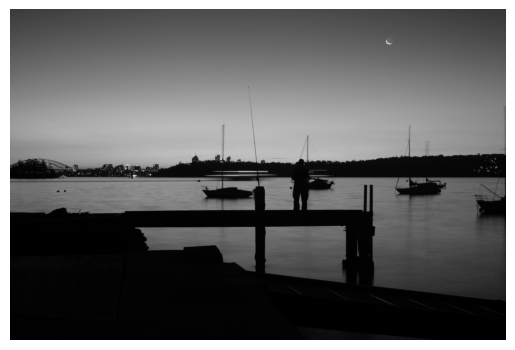

In [15]:
# Code to use image file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

input_file = 'Paysage_1536x1024.raw'
downloaded = drive.CreateFile({'id':'1c2cEQktdfbdFKdDNC_4vc5Jf9D-bEJrF'})
downloaded.GetContentFile(input_file)

from matplotlib import pyplot as plt
import numpy as np
img = np.fromfile(input_file, dtype=np.uint8)
imageSize = (1024, 1536)
img = img.reshape(imageSize)

plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

In [16]:
%%writefile tecSanLib.cpp

#include <iostream>
#include "image.h"
#include "processing.h"

int main()
{
    using file_input_type = unsigned char;
    using pixel_type = unsigned char;
    using file_output_type = unsigned char;

    constexpr int width{ 1536 }, height{ 1024 };

	  // Create two new images
    v2_0::Image<file_input_type> imgIn1(width, height);
    if (!(imgIn1.read("Paysage_1536x1024.raw")))
        return -1;
    
    // Convert to processing type
    auto img1{ imgIn1.convert<pixel_type>() };

    // Otsu thresholding (class version)
    v2_0::OtsuThresholding<pixel_type> otsuThresholding(img1, true);
    otsuThresholding.update();

    // Write image to raw file (rescaling because type narrowing)
    auto imgOut1{ img1.convert<file_output_type>(true) };
    imgOut1.write("binary.raw");

    return 0;
}

Overwriting tecSanLib.cpp


In [17]:
%%shell
g++ tecSanLib.cpp -o output
./output

Threshold value = 67

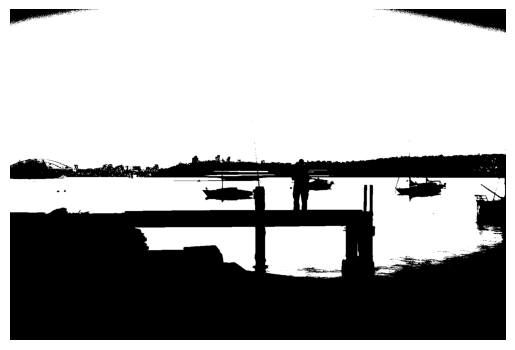

In [18]:
from matplotlib import pyplot as plt
import numpy as np

binary_file = 'binary.raw'
img = np.fromfile(binary_file, dtype=np.uint8)
imageSize = (1024, 1536)
img = img.reshape(imageSize)

plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()